In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from CartPole_ import CartPole
from CartPoleNoise_ import CartPoleGaussianNoisyDyn, CartPoleGaussianNoisyObs, CartPoleGaussianNoisyObsDyn

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'image.cmap':'jet'
})

from NonLinearObserver_ import NonLinearObserver
from LinearController_ import LinearController

from shared import get_initial_states, plot_rollout, np_to_string, get_scan_states_ranges, plot_actual_and_predicted_states_contour

In [3]:
# Task 2.1

In [4]:
target = CartPole(False)

In [5]:
# load model from save file

model_2_1 = NonLinearObserver.initialize_model(N=14, M=9, with_action=False)
model_2_1.load_model("./models/2_1__14__9")

In [6]:
# Observe model roll outs for a variety of initial conditions

initial_states = list(get_initial_states().values())
initial_states

[array([0.        , 0.01      , 3.14159265, 0.01      , 0.        ]),
 array([0.        , 2.        , 3.24159265, 2.        , 0.        ]),
 array([0.        , 8.        , 3.24159265, 8.        , 0.        ]),
 array([ 0.        , 14.        ,  3.24159265, 14.        ,  0.        ]),
 array([0.  , 0.01, 0.01, 0.01, 0.  ]),
 array([0.  , 0.01, 0.5 , 0.01, 0.  ]),
 array([0. , 2. , 0.5, 2. , 0. ]),
 array([0. , 8. , 0.5, 8. , 0. ])]

Text(0.5, 0.98, 'Actual (solid) rollout and predicted (dotted) rollout for different initial states')

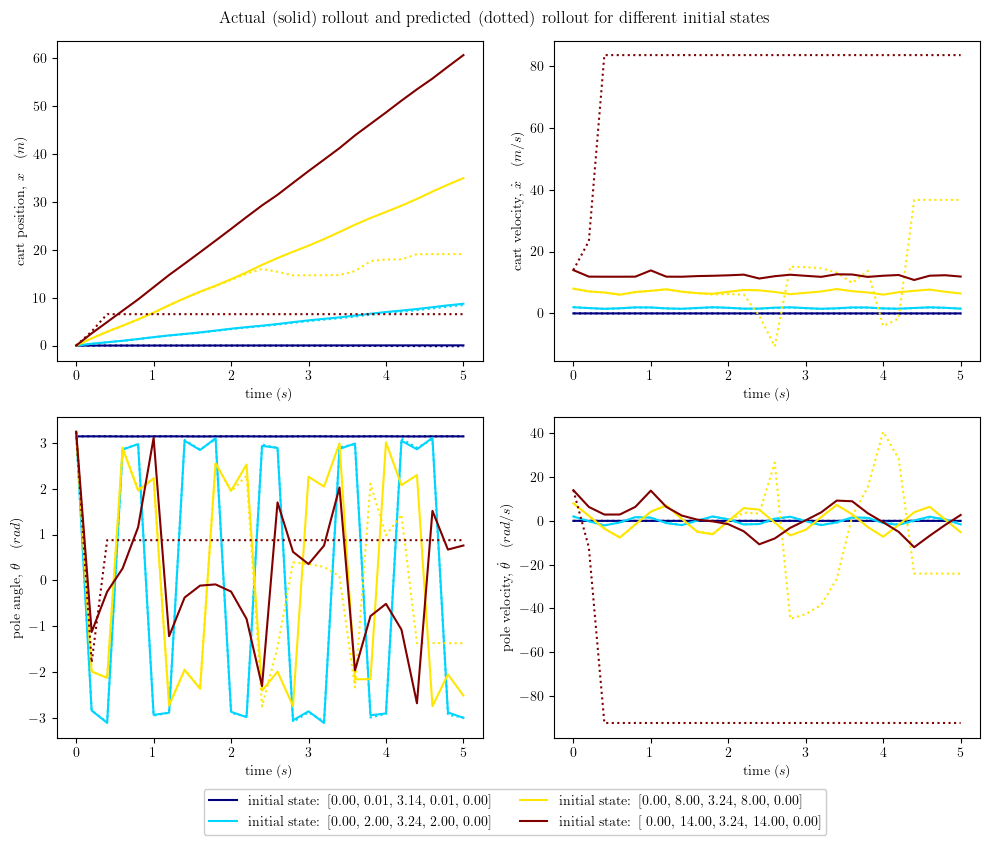

In [7]:
n = 4
colors = plt.cm.jet(np.linspace(0, 1, n))
fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='tight')

for i in range(n):
    s0 = initial_states[i]
    x, y = target.simulate(time=5, state=s0, remap=True)
    x_hat, y_hat = model_2_1.simulate(time=5, state=s0, remap=True)

    plot_rollout(x, y, axs, fig, label=f"initial state: {np_to_string(s0)}", color=colors[i])
    plot_rollout(x_hat, y_hat, axs, fig, linestyle='dotted', color=colors[i])

lgd = fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)
fig.suptitle("Actual (solid) rollout and predicted (dotted) rollout for different initial states")

Text(0.5, 0.98, 'Actual (solid) rollout and predicted (dotted) rollout for different initial states')

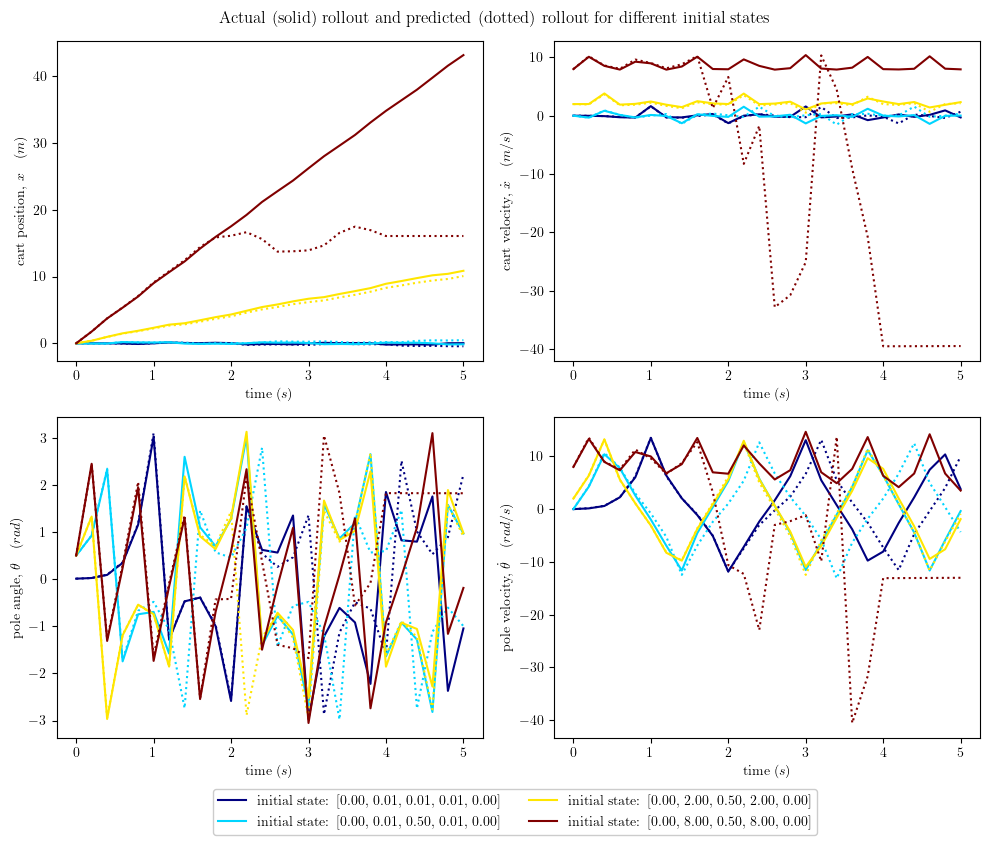

In [8]:
n = 4
colors = plt.cm.jet(np.linspace(0, 1, n))
fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='tight')

for i in range(n):
    s0 = initial_states[4:][i]
    x, y = target.simulate(time=5, state=s0, remap=True)
    x_hat, y_hat = model_2_1.simulate(time=5, state=s0, remap=True)

    plot_rollout(x, y, axs, fig, label=f"initial state: {np_to_string(s0)}", color=colors[i])
    plot_rollout(x_hat, y_hat, axs, fig, linestyle='dotted', color=colors[i])

lgd = fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)
fig.suptitle("Actual (solid) rollout and predicted (dotted) rollout for different initial states")

Text(0.5, 0.98, 'Actual (solid) rollout and predicted (dotted) rollout for different initial cart positions')

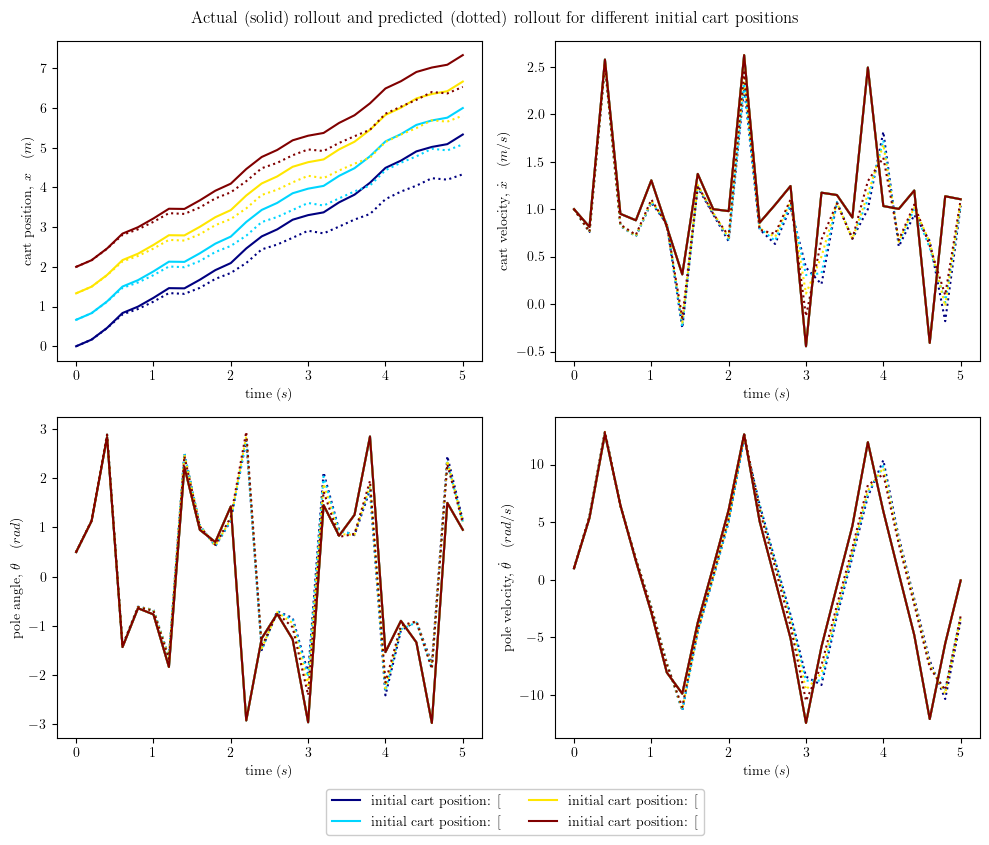

In [9]:
# How does the model perform for non-zero cart positions?
s0 = np.array([0, 1, 0.5, 1, 0])

n = 4
colors = plt.cm.jet(np.linspace(0, 1, n))
fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='tight')

cart_positions = np.linspace(0, 2, n)

for i in range(n):
    s0[0] = cart_positions[i]
    x, y = target.simulate(time=5, state=s0, remap=True)
    x_hat, y_hat = model_2_1.simulate(time=5, state=s0, remap=True)

    plot_rollout(x, y, axs, fig, label=f"initial cart position: {np_to_string(s0)[0]}", color=colors[i])
    plot_rollout(x_hat, y_hat, axs, fig, linestyle='dotted', color=colors[i])

lgd = fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)
fig.suptitle("Actual (solid) rollout and predicted (dotted) rollout for different initial cart positions")

In [10]:
# The model tracks well for 2 oscillations
# For the stable position, considering the blue/yellow, this correpsonds to a time period of about 2.4 seconds
# For the unstable position, considering the blue/yellow, the time period is about 2.5 too
# Hence, for subsequent controllers, we aim for a tracking time period of at least 2.4
# We find that the model tracks better for "intermediate" initial conditions -- not too small or not too large
# This is evident as the model performs worse for the dark blue and dark red lines.

In [11]:
# Now, we use the contour plots to get operating ranges for a time period of 3 seconds (at least 2 oscillations)
# This helps to define our search space when optimizing the linear policy later


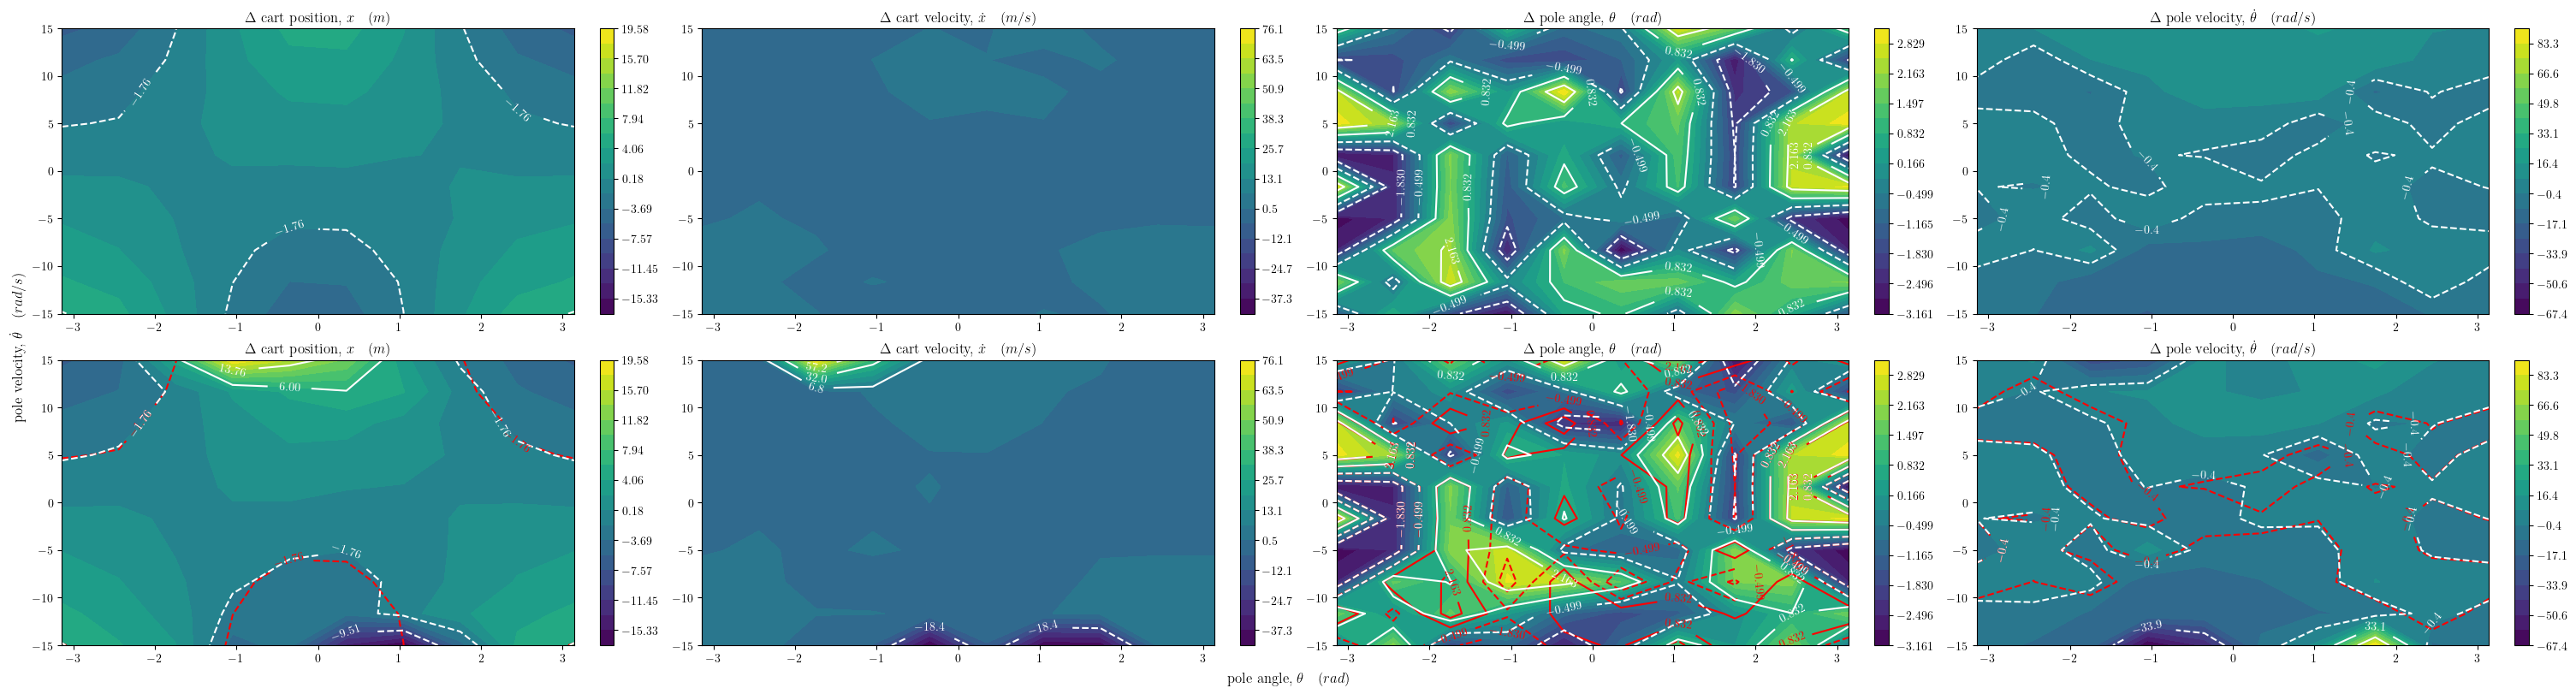

In [14]:
from shared import plot_actual_and_predicted_states_contour, get_contour_levels

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 2, 3 # scan pole angle and pole velocity
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')


s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=3, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=3, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)

fig.savefig("./assets2_revised/task2_1__contour_T3_2_3.png")

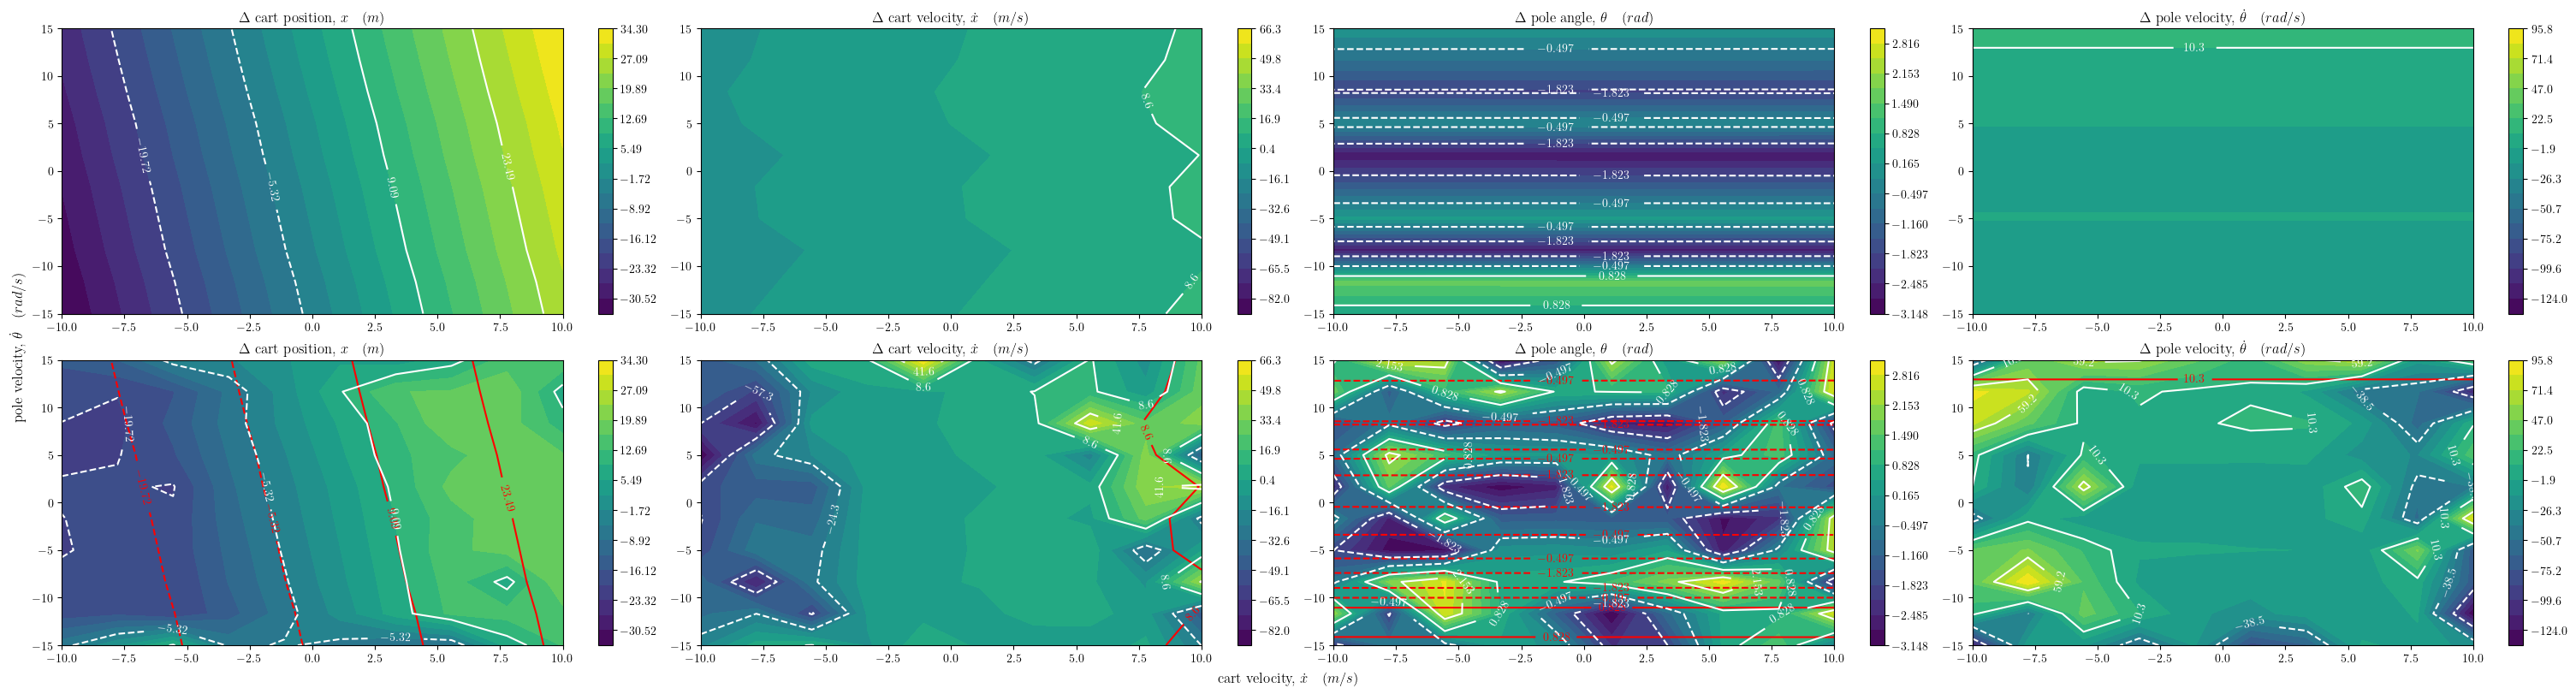

In [15]:
from shared import plot_actual_and_predicted_states_contour

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 1, 3 # scan cart velocity and pole velocity
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')


s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=3, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=3, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)

fig.savefig("./assets2_revised/task2_1__contour_T3_1_3.png")



/Users/chongzhenyuen/Library/CloudStorage/OneDrive-UniversityofCambridge/2A/SF3-Project-Machine-Learning-Cartpole-Duplicate/shared.py:214: UserWarning: No contour levels were found within the data range.
  c4 = axs[3].contour(x, y, z3, colors=colors, levels=levels[3][::4])


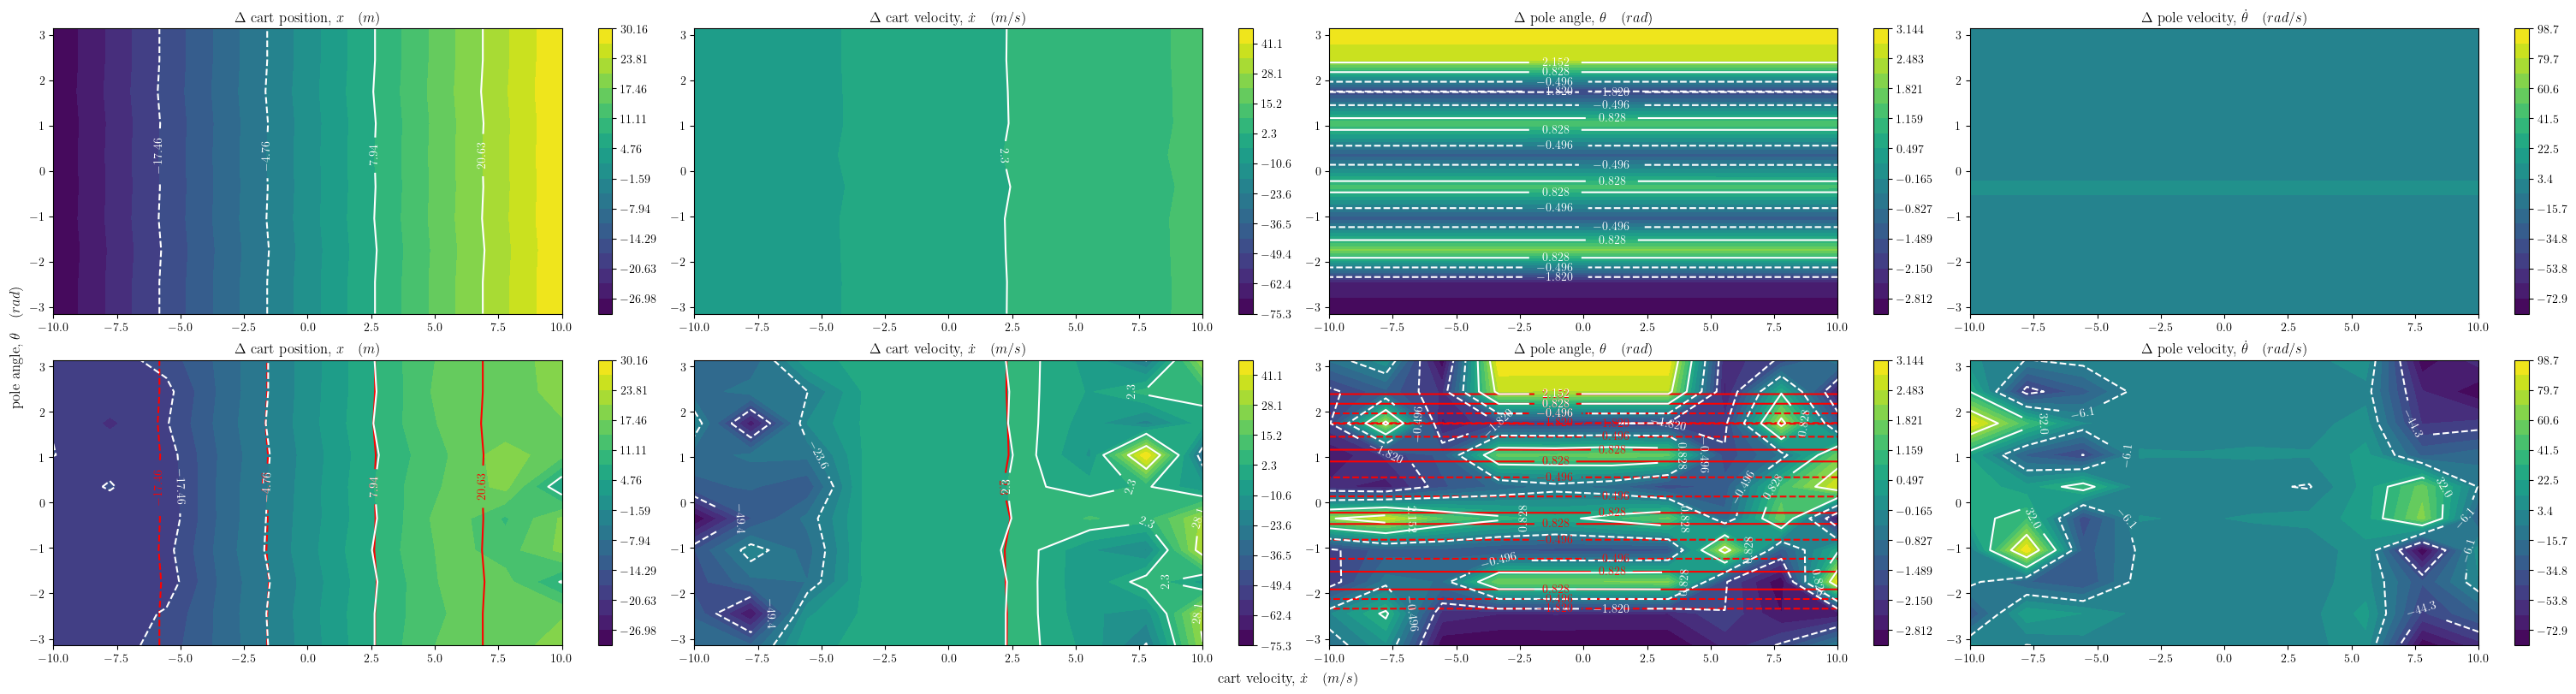

In [16]:
from shared import plot_actual_and_predicted_states_contour

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 1, 2 # scan cart velocity and pole angle
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')


s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=3, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=3, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)

fig.savefig("./assets2_revised/task2_1__contour_T3_1_2.png")


In [17]:
# How well does the model track for 2 seconds?


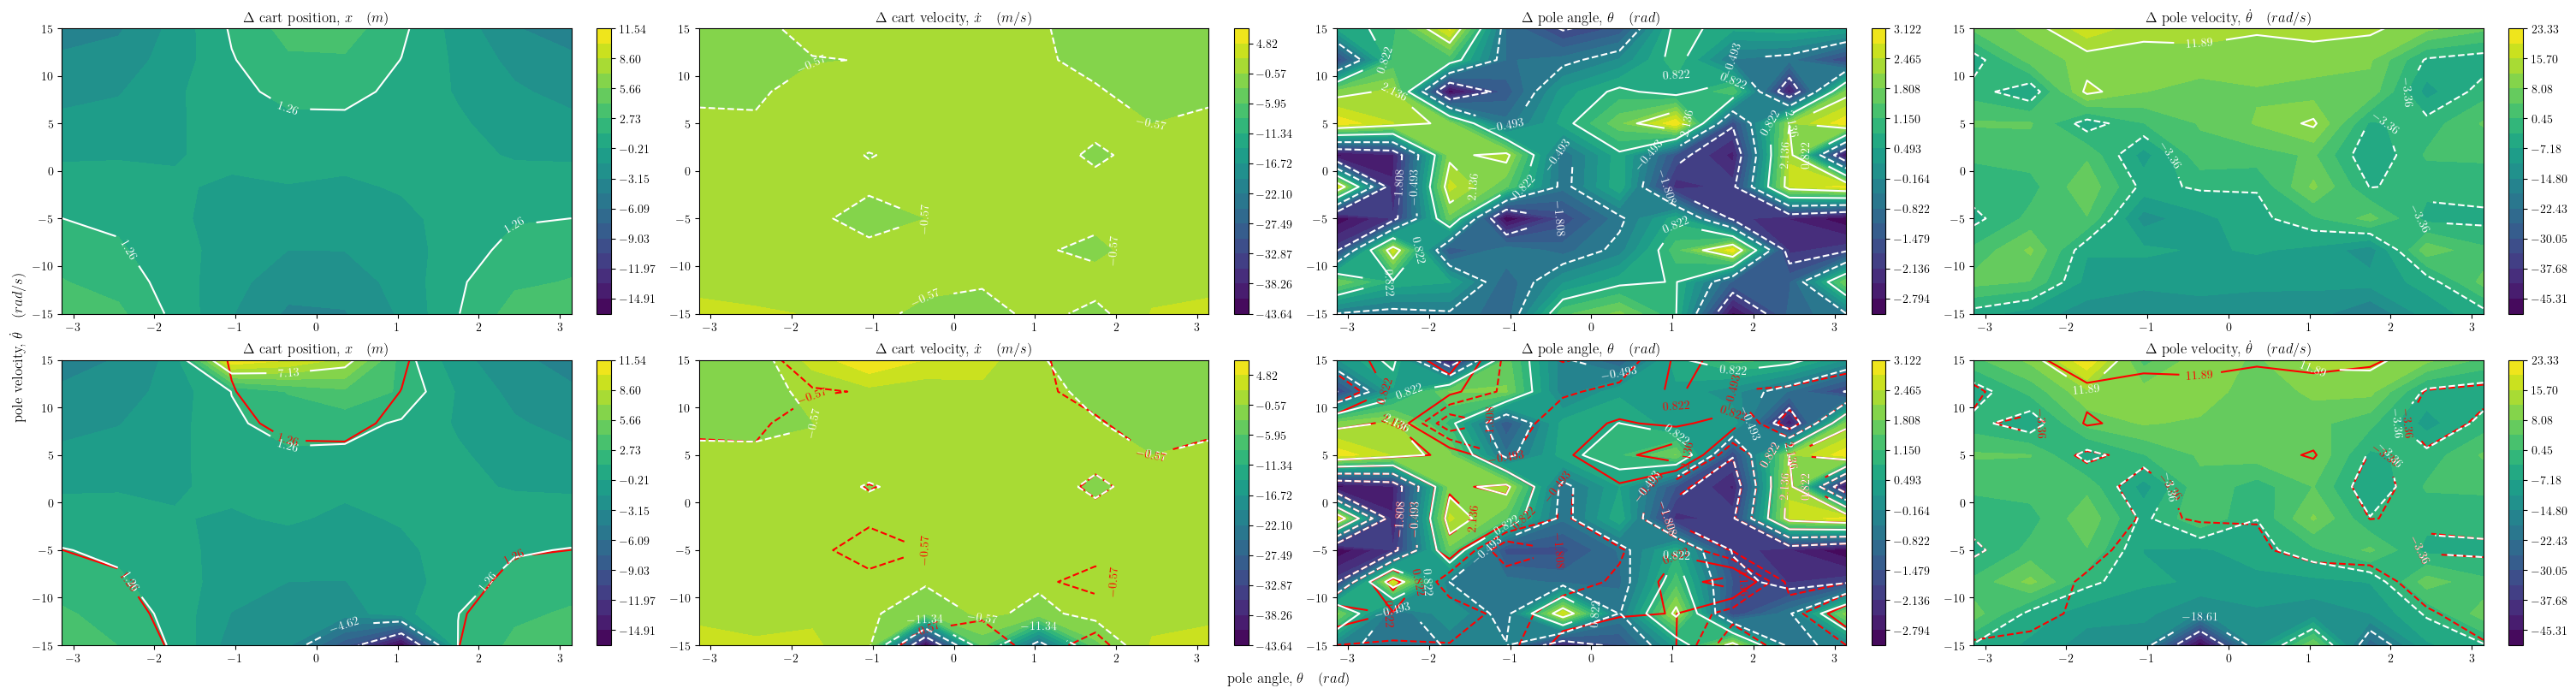

In [19]:
from shared import plot_actual_and_predicted_states_contour

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 2, 3 # scan pole angle and pole velocity
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')


s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=2, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=2, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)



NameError: name 'get_contour_levels' is not defined

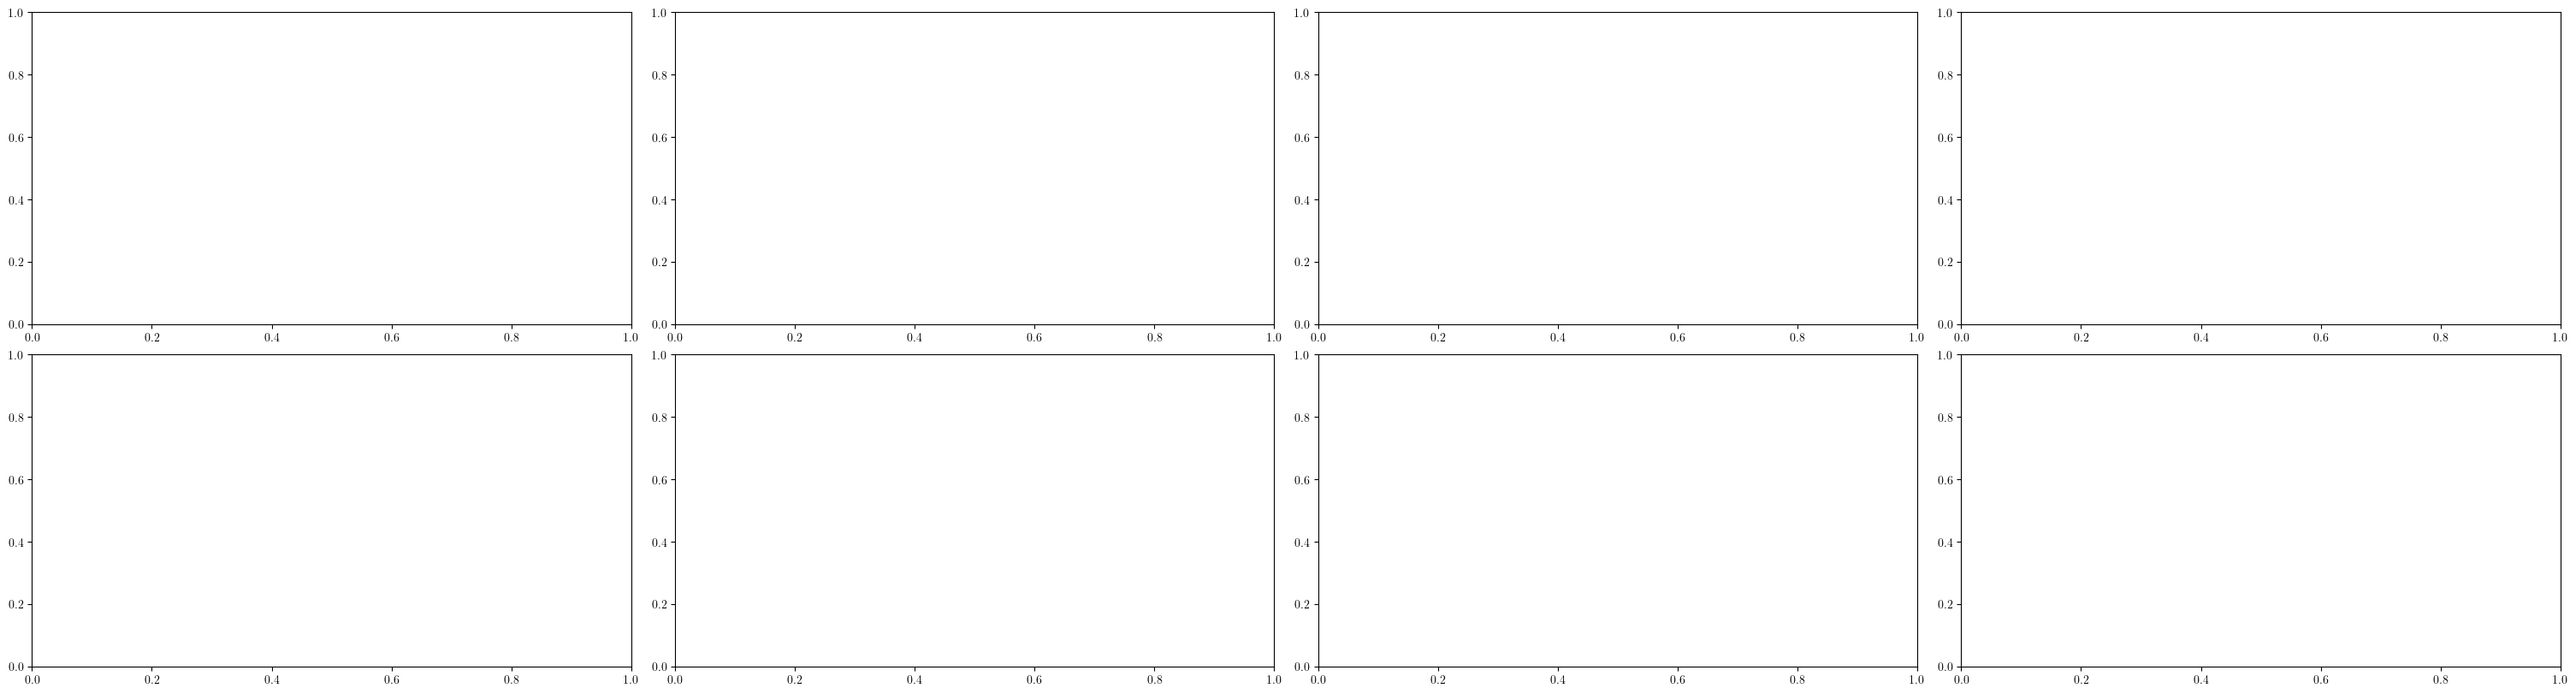

In [6]:
###### from shared import plot_actual_and_predicted_states_contour

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 1, 3 # scan cart velocity and pole velocity
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')


s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=2, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=2, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)



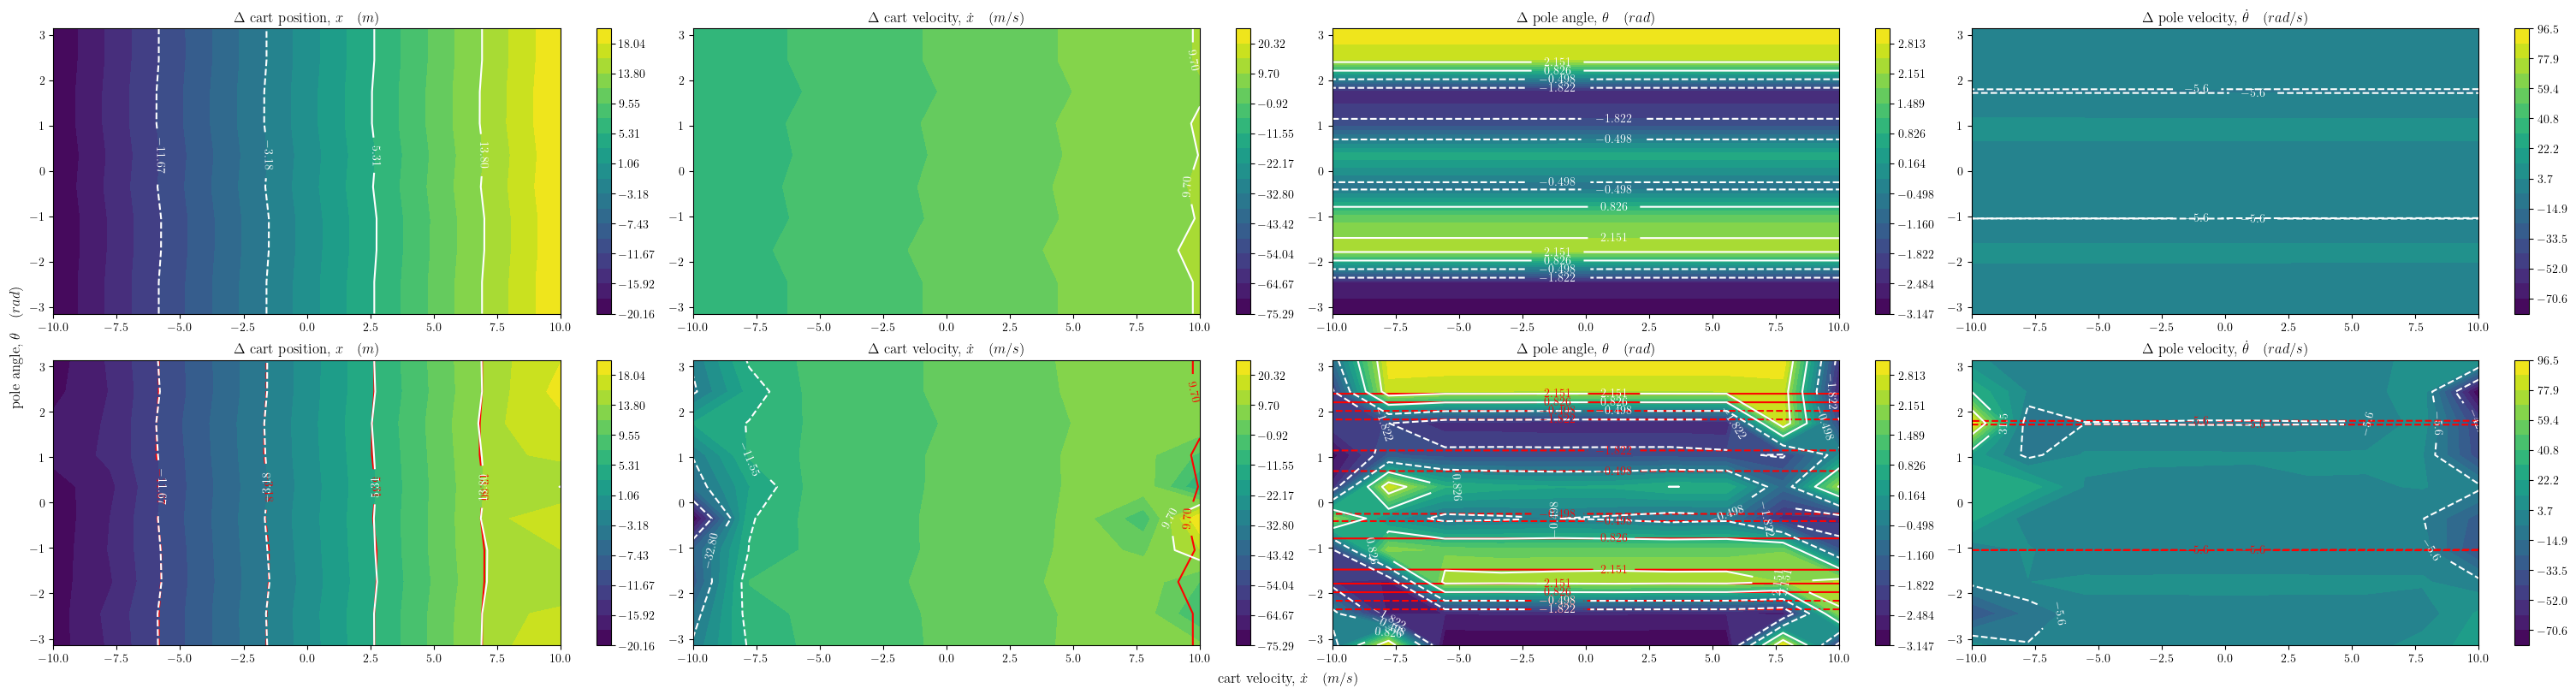

In [ ]:
from shared import plot_actual_and_predicted_states_contour, get_contour_levels

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 1, 2 # scan cart velocity and pole angle
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')


s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=2, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=2, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)


In [ ]:
# What about a time period of 1?

In [ ]:
from shared import plot_actual_and_predicted_states_contour

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 2, 3 # scan pole angle and pole velocity
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')


s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=1, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=1, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)



In [ ]:
from shared import plot_actual_and_predicted_states_contour

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 1, 3 # scan cart velocity and pole velocity
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')


s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=1, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=1, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)


In [ ]:
from shared import plot_actual_and_predicted_states_contour, get_contour_levels

fig, axs = plt.subplots(2, 4, figsize=(30, 8), layout='constrained')

n = 10
p, q = 1, 2 # scan cart velocity and pole angle
s0 = np.array([0, 0, 0.5, 0, 0])
scan_state_ranges  = get_scan_states_ranges(n)

x, y = np.meshgrid(scan_state_ranges[p], scan_state_ranges[q], indexing='ij')

s = np.zeros((len(x), len(y), 4))
s_hat = np.zeros((len(x), len(y), 4))

for i in range(len(x)):
    for j in range(len(y)):
        s0[p] = x[i][j]
        s0[q] = y[i][j]
        
        _, s_actual = target.simulate(time=1, state=s0, remap=True)
        _, s_predicted = model_2_1.simulate(time=1, state=s0, remap=True)
        
        s[i][j] = s_actual[-1, :]
        s_hat[i][j] = s_predicted[-1, :]

        
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())

c_levels = get_contour_levels(s, s_hat)

plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[0], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='red', levels=c_levels)
plot_actual_and_predicted_states_contour(x, y, s_hat, p=p, q=q, fig=fig, axs=axs[1], xlim=xlim, ylim=ylim, colors='white', levels=c_levels)